<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [3]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [5]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [6]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


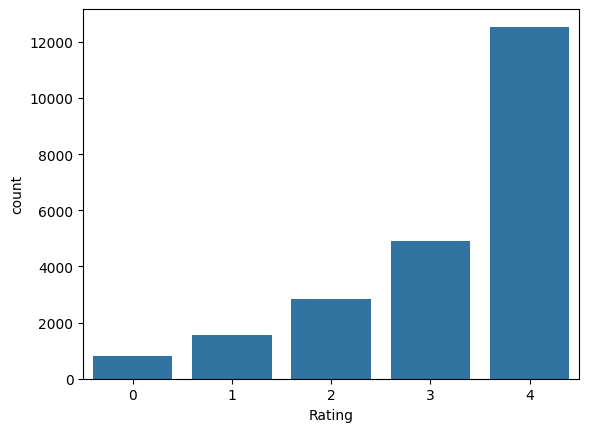

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

vector_reviews = df_reviews['Review Text'].to_numpy()
vector_reviews

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       ...,
       "This fit well, but the top was very see through. this never would have worked for me. i

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
vector_reviews.shape

(22641,)

In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus

corpus = ' '.join(vector_reviews)

In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?

len(corpus)

7011643

In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

# Proceso de tokenización
tok = Tokenizer(num_words = num_words) 
tok.fit_on_texts(tokens) 

In [16]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tok.word_index
len(word_index)

14847

In [17]:
print(word_index)

{'the': 1, 'i': 2, 'and': 3, 'a': 4, 'it': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'on': 11, 'for': 12, 'of': 13, 'with': 14, 'was': 15, 'so': 16, 'my': 17, 'dress': 18, 'not': 19, 'that': 20, 'love': 21, 'size': 22, 'very': 23, 'have': 24, 'top': 25, 'fit': 26, 'are': 27, 'like': 28, 'be': 29, 'as': 30, 'me': 31, 'wear': 32, "it's": 33, 'great': 34, 'too': 35, "i'm": 36, 'or': 37, 'am': 38, 'just': 39, 'you': 40, 'would': 41, 'they': 42, 'up': 43, 'at': 44, 'fabric': 45, 'small': 46, 'color': 47, 'look': 48, 'if': 49, 'more': 50, 'really': 51, 'ordered': 52, 'little': 53, 'perfect': 54, 'will': 55, 'one': 56, 'these': 57, 'flattering': 58, 'well': 59, 'an': 60, 'soft': 61, 'out': 62, 'back': 63, 'because': 64, 'had': 65, 'can': 66, '\r': 67, 'comfortable': 68, 'cute': 69, 'nice': 70, 'than': 71, 'bought': 72, 'beautiful': 73, 'when': 74, 'all': 75, 'looks': 76, 'bit': 77, 'fits': 78, 'large': 79, 'shirt': 80, 'down': 81, 'which': 82, 'material': 83, 'much': 84, 'them': 85,

In [18]:
# Alumno: Convertir las palabras/tokens a números

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(vector_reviews)

In [19]:
# Determinar cual es la oración más larga
oracion_mas_larga = max(sequences, key=len)

print("La oracion mas larga es:", oracion_mas_larga)
print("La cantidad de palabras es:", len(oracion_mas_larga))
print("El indice es:", sequences.index(oracion_mas_larga))

La oracion mas larga es: [2, 21, 771, 218, 2, 21, 1, 83, 3, 145, 13, 7, 480, 74, 2, 196, 1, 447, 218, 20, 364, 62, 2, 516, 8, 17, 494, 106, 8, 179, 56, 11, 36, 107, 4, 79, 9, 4, 25, 425, 9, 4, 247, 60, 418, 42, 117, 65, 4, 79, 8, 179, 16, 2, 104, 5, 9, 1, 123, 791, 2, 118, 778, 115, 1, 25, 11, 5, 157, 28, 2, 15, 1609, 504, 160, 13, 1, 25, 2, 1777, 1, 22, 3, 5, 15, 4, 79, 33, 4, 1376, 1, 25, 6, 51, 69, 49, 40, 27, 1, 502, 77, 652, 37, 583, 147, 43, 4, 22, 37, 262, 49, 40, 27, 107, 4]
La cantidad de palabras es: 115
El indice es: 16263


In [20]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [21]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

### 1b - Balanceo del dataset

Para balancear el dataset, vamos a unificar los Ratings 0, 1 y 2 en "Negativos", 3 en "Intermedios" y 4 en "Positivos"

Luego utilizaremos tecnicas de Oversampling y Undersampling

In [22]:
df_reviews['Ratings_unif'] = pd.cut(df_reviews['Rating'], bins=[-1, 2, 3, 4], labels=['Negativos', 'Intermedios', 'Positivos'])

# Puedes eliminar la columna de etiquetas original si ya no es necesaria
df_reviews.drop('Rating', axis=1, inplace=True)

In [23]:
print(df_reviews.head())

                                         Review Text Ratings_unif
0  Absolutely wonderful - silky and sexy and comf...  Intermedios
1  Love this dress!  it's sooo pretty.  i happene...    Positivos
2  I had such high hopes for this dress and reall...    Negativos
3  I love, love, love this jumpsuit. it's fun, fl...    Positivos
4  This shirt is very flattering to all due to th...    Positivos


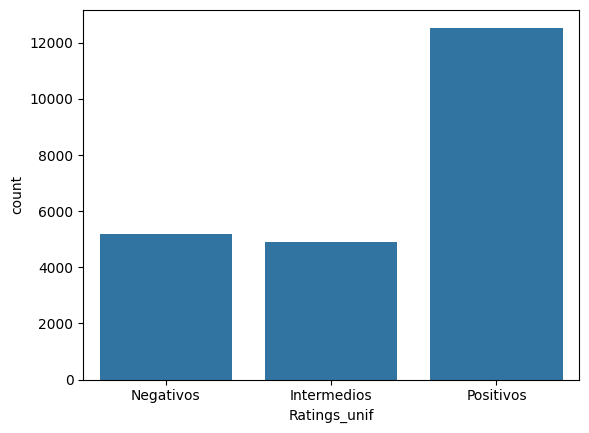

In [24]:
sns.countplot(x='Ratings_unif', data=df_reviews)
plt.show()

In [25]:
num_classes = 3

# Transformar los datos a oneHotEncoding
y = to_categorical(df_reviews['Ratings_unif'].astype('category').cat.codes, num_classes = num_classes)
y.shape

(22641, 3)

In [26]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_reviews['Ratings_unif'].values)

In [27]:
print(y_train.shape)
print(y_test.shape)

(18112, 3)
(4529, 3)


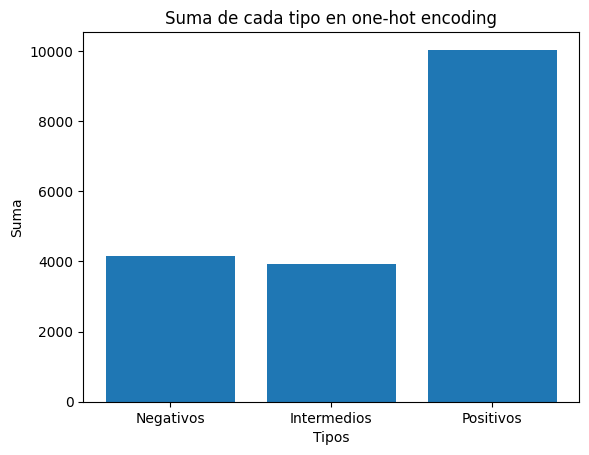

In [28]:
suma_por_tipo = np.sum(y_train, axis=0)
nombres_tipos = ['Negativos', 'Intermedios', 'Positivos']

plt.bar(nombres_tipos, suma_por_tipo)

# Agregar etiquetas y título
plt.xlabel('Tipos')
plt.ylabel('Suma')
plt.title('Suma de cada tipo en one-hot encoding')

# Mostrar el gráfico
plt.show()

In [29]:
#BALANCEO DE DATASET USANDO OVERSAMPLING
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Aplicar SMOTE

oversampler = RandomOverSampler(random_state=42, sampling_strategy={0: 7000, 1: 7000})
undersampler = RandomUnderSampler(random_state=42, sampling_strategy={2: 8000})

X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

In [30]:
print(y_resampled.shape)

(22000, 3)


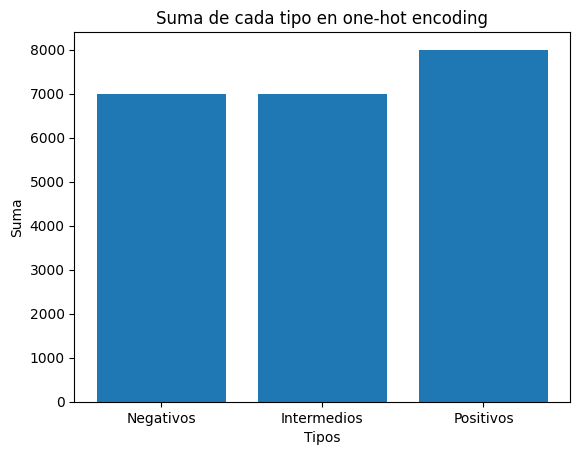

In [31]:
suma_por_tipo = np.sum(y_resampled, axis=0)
nombres_tipos = ['Negativos', 'Intermedios', 'Positivos']

plt.bar(nombres_tipos, suma_por_tipo)

# Agregar etiquetas y título
plt.xlabel('Tipos')
plt.ylabel('Suma')
plt.title('Suma de cada tipo en one-hot encoding')

# Mostrar el gráfico
plt.show()

In [32]:
# Alumno: determinar la dimensiones de entrada y salida

# Determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
print("in_shape", in_shape, ", out_shape", num_classes)

in_shape 115 , out_shape 3


### 2 - Entrenar el modelo con Embeddings + LSTM

In [33]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [34]:
from keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [35]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=[f1_score])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3

In [36]:
hist = model.fit(X_resampled, y_resampled, epochs=20, validation_data=(X_test, y_test))
#hist = model.fit(X_resampled, y_resampled, epochs=20, validation_split=0.2)


Epoch 1/20
688/688 [==============================] - 45s 60ms/step - loss: 0.8187 - f1_score: 0.5398 - val_loss: 0.7466 - val_f1_score: 0.6582
Epoch 2/20
688/688 [==============================] - 42s 61ms/step - loss: 0.6702 - f1_score: 0.6902 - val_loss: 0.7197 - val_f1_score: 0.6683
Epoch 3/20
688/688 [==============================] - 42s 61ms/step - loss: 0.5914 - f1_score: 0.7453 - val_loss: 0.8168 - val_f1_score: 0.6363
Epoch 4/20
688/688 [==============================] - 40s 59ms/step - loss: 0.5333 - f1_score: 0.7774 - val_loss: 0.9176 - val_f1_score: 0.6148
Epoch 5/20
688/688 [==============================] - 42s 61ms/step - loss: 0.4782 - f1_score: 0.8069 - val_loss: 0.8683 - val_f1_score: 0.6541
Epoch 6/20
688/688 [==============================] - 40s 58ms/step - loss: 0.4257 - f1_score: 0.8308 - val_loss: 0.9753 - val_f1_score: 0.6345
Epoch 7/20
688/688 [==============================] - 39s 57ms/step - loss: 0.3817 - f1_score: 0.8512 - val_loss: 0.9486 - val_f1_score:

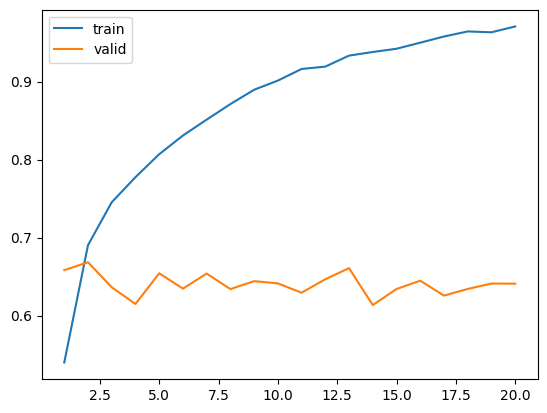

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['f1_score']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_f1_score'], label='valid')
plt.show()

In [38]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 3s 21ms/step - loss: 1.7504 - f1_score: 0.6408


[1.7503621578216553, 0.6408292055130005]

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM

In [39]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
# !curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

In [40]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [41]:
model_fasttext = FasttextEmbeddings()
# Mirar cómo sube el uso de RAM en colab!

In [42]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [43]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=num_classes, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=[f1_score])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [44]:
#hist2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.2)
hist2 = model2.fit(X_resampled, y_resampled, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
688/688 [==============================] - 54s 74ms/step - loss: 1.0647 - f1_score: 0.1335 - val_loss: 1.0032 - val_f1_score: 0.2583
Epoch 2/20
688/688 [==============================] - 50s 72ms/step - loss: 1.0110 - f1_score: 0.3100 - val_loss: 0.9689 - val_f1_score: 0.3506
Epoch 3/20
688/688 [==============================] - 49s 72ms/step - loss: 0.9778 - f1_score: 0.3758 - val_loss: 0.9370 - val_f1_score: 0.4025
Epoch 4/20
688/688 [==============================] - 50s 73ms/step - loss: 0.9416 - f1_score: 0.4277 - val_loss: 0.9207 - val_f1_score: 0.4779
Epoch 5/20
688/688 [==============================] - 49s 72ms/step - loss: 0.9005 - f1_score: 0.4795 - val_loss: 0.9332 - val_f1_score: 0.5275
Epoch 6/20
688/688 [==============================] - 50s 72ms/step - loss: 0.8522 - f1_score: 0.5318 - val_loss: 0.9564 - val_f1_score: 0.5127
Epoch 7/20
688/688 [==============================] - 50s 72ms/step - loss: 0.8065 - f1_score: 0.5772 - val_loss: 0.9275 - val_f1_score:

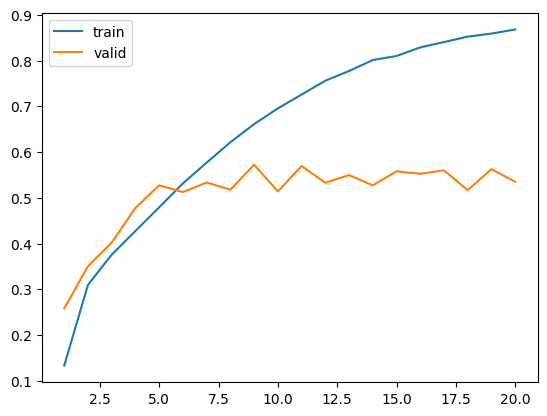

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['f1_score']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_f1_score'], label='valid')
plt.show()

In [46]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 4s 28ms/step - loss: 1.6363 - f1_score: 0.5353


[1.6363037824630737, 0.5352784395217896]

### 4 - Conclusiones

Utilizando técnicas simples de balanceo de datos, las métricas de ambos modelos mejoraron considerablemente, manteniéndose la mayor efectividad en el modelo que entrena sus propios embeddings, el cual logró las mejores metricas totales.

Sin embargo, sigue manteniéndose el overfit en todos los casos, por lo que se podrían probar modelos menos complejos.